but as main next step, I would suggest you can start building out the dowhy PR now, that adds support for time series data. You can follow the standard data format that we had discussed. Assume that the user can provide lag parameter for each edge (expressed as an attribute in networkx graph object). And then you will need to create a graph, and then try to see if you can make a simple method work (E.g. ,linear regression for effect estimation)

as demo, you can include a notebook that uses the petshop dataset and estimates impact of certain variables

for linear regression, here are the steps to be followed:
user provides networkx graph with edge attributes for time lag (e.g., user can say X at t-2, t-1, affects Y at t.)
dowhy inputs dataframe and user graph.
dowhy internal code:
based on the edge attributes, expand the dataframe to contain lagged column names . E.g., if Y is the outcome, we need to add a column called X_t-1 that now contains shifted values.
based on the edge attributes, also unroll the graph. so now the graph will have new variables like X_t-1 and edge from x_t-1 to Y.(the names of new variables are exactly the same as the names of columns in dataframe)
Once step 3 is done, you can just run any estimator as standard (E.g., you can run linear regression)

In [ ]:
# time lag should also be inputed along with the edge, the time lag may be represented as an annotation on the edge, or a replacement
# for the edge length
# edges should be made directed too : done

In [ ]:
# a function to shift the columns in a dataframe by a certain number of rows
# this is useful for creating a new column that is the value of a column at a previous time point
# or for creating a new column that is the value of a column at a future time point
# the function is called shift_columns
# the function takes 3 arguments:
# 1. df - the dataframe
# 2. column - the column to shift
# 3. shift - the number of rows to shift the column by
# the function returns a new dataframe with the shifted column
# if shift is positive, the column is shifted down
# if shift is negative, the column is shifted up
# if shift is zero, the column is not shifted
# if the column is shifted down, the new values are NaNs
# if the column is shifted up, the last values are dropped

def shift_columns(df, column, shift):
    new_df = df.copy()
    if shift > 0:
        new_df[column] = new_df[column].shift(shift, axis=0, fill_value=None)
    elif shift < 0:
        new_df[column] = new_df[column].shift(shift, axis=0, fill_value=None)
        new_df.drop(new_df.index[0:abs(shift)], axis=0, inplace=True)
    return new_df

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def create_graph_from_user():
    # Initialize an empty directed graph
    graph = nx.DiGraph()
    
    # Instructions for the user
    print("Enter the graph as a list of edges with weights. Enter 'done' when you are finished.")
    print("Each edge should be entered in the format 'node1 node2 weight'. For example: 'A B 4'")
    
    # Loop to receive user input
    while True:
        edge = input("Enter an edge: ")
        if edge.lower() == "done":
            break
        edge = edge.split()
        if len(edge) != 3:
            print("Invalid edge. Please enter an edge in the format 'node1 node2 weight'.")
            continue
        node1, node2, weight = edge
        try:
            weight = float(weight)
        except ValueError:
            print("Invalid weight. Please enter a numerical value for the weight.")
            continue
        graph.add_edge(node1, node2, weight=weight)
    
    return graph

In [3]:
def create_graph_from_csv(file_path):
    # Read the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    
    # Initialize an empty directed graph
    graph = nx.DiGraph()
    
    # Add edges with weights to the graph
    for index, row in df.iterrows():
        graph.add_edge(row['node1'], row['node2'], weight=row['weight'])
    
    return graph

In [4]:
def pretty_print_graph(graph):
    # Display the entered graph
    print("\nGraph edges with weights:")
    for edge in graph.edges(data=True):
        print(f"{edge[0]} -> {edge[1]} with weight {edge[2]['weight']}")

In [5]:
def display_networkx_graph(graph):
    # Draw and display the graph
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True)
    labels = nx.get_edge_attributes(graph, 'weight')
    nx.draw_networkx_edge_labels(graph, pos, edge_labels=labels)
    plt.show()


Graph edges with weights:
1 -> 2 with weight 4
2 -> 3 with weight 5
4 -> 5 with weight 1
5 -> 6 with weight 3


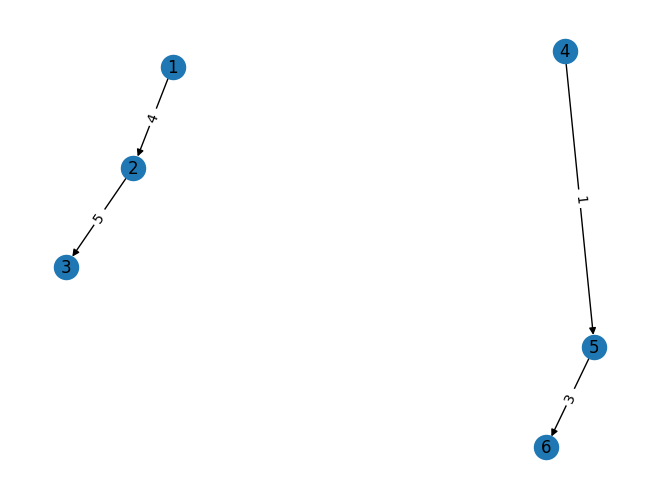

In [6]:
# Prompt user to input the path to the CSV file
file_path = "./temporal_graph.csv"

# Create the graph from the CSV file
graph = create_graph_from_csv(file_path)
pretty_print_graph(graph)
display_networkx_graph(graph)

In [34]:
# create a function that returns a dictionary of node:weight for all the parent nodes of a given node in the networkx
# graph
def find_lagged_parent_nodes(graph, node):
    parent_nodes = {}
    for n in graph.predecessors(node):
        edge_data = graph.get_edge_data(n, node)
        if 'weight' in edge_data:
            parent_nodes[str(n)] = edge_data['weight']
    return parent_nodes

In [35]:
# read the dataframe in a csv format from the user, and then ask the user to select any 2 rows for 
# the effect estimation usecase
dataset_path="dummy_dataset.csv"
dataframe=pd.read_csv(dataset_path)

# ask the node for which effect estimation has to be done
child_node = int(input("enter the node which requires effect estimation to be done"))

# find the parent nodes of the given node with respective lag times
parents = find_lagged_parent_nodes(graph, child_node)
parents

{'4': 1}

In [36]:
# once we have the parent dictionary then we can parse it and shift columns within the dataframe with the appropriate lag
def shift_columns(df, parents):
    new_df = df.copy()
    for column, shift in parents.items():
        column=str(column)
        if shift > 0:
            new_df[column] = new_df[column].shift(shift, axis=0, fill_value=None)
        # elif shift < 0:
        #     new_df[column] = new_df[column].shift(shift, axis=0, fill_value=None)
        #     new_df.drop(new_df.index[0:abs(shift)], axis=0, inplace=True)
    return new_df

In [37]:
time_shifted_df = shift_columns(dataframe,parents)

In [38]:
time_shifted_df.head()

,1,2,3,4,5,6
0,0.1,0.2,0.3,NaN,0.5,0.6
1,0.1,0.2,0.3,1.0,0.5,0.6
2,0.1,0.2,0.3,2.0,0.5,0.6
3,0.1,0.2,0.3,3.0,0.5,0.6
4,0.1,0.2,0.3,4.0,0.5,0.6


In [39]:
def filter_columns(df, child_node, parent_nodes):
    columns_to_keep = [str(child_node)] + list(parent_nodes.keys())
    filtered_df = df[columns_to_keep]
    return filtered_df

In [41]:
filtered_ts_df = filter_columns(time_shifted_df,child_node,parents)

In [45]:
filtered_ts_df.fillna(0,inplace=True)
filtered_ts_df.head()

C:\Users\t-ashutoshs\AppData\Local\Temp\ipykernel_19512\3305010502.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_ts_df.fillna(0,inplace=True)


,5,4
0,0.5,0.0
1,0.5,1.0
2,0.5,2.0
3,0.5,3.0
4,0.5,4.0


In [ ]:
# perform causal effect estimation on this new dataset
